In [ ]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [ ]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from stardist.models import StarDist2D
from stardist.plot import render_label
from src.utils.helpers import clean_mask, cut_out_image
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops
from typing import Dict
from numpy.typing import NDArray

In [3]:
model = StarDist2D.from_pretrained("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [4]:
image_paths = sorted(
    [
        "data/images/" + path
        for path in os.listdir("data/images")
        if not path.startswith(".")
    ]
)
mask_paths = sorted(
    [
        "data/masks/" + path
        for path in os.listdir("data/masks")
        if not path.startswith(".")
    ]
)
images = list(map(tifffile.imread, image_paths))
masks = list(map(tifffile.imread, mask_paths))
data = list(zip(images, masks))

In [ ]:
from src.utils.helpers import compare_two_images

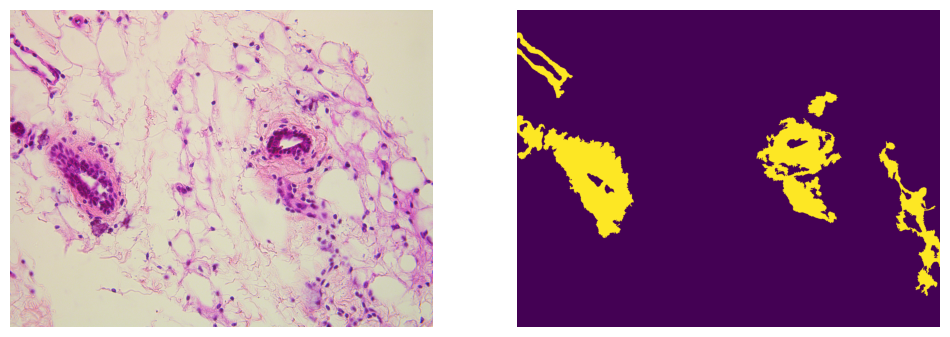

In [20]:
compare_two_images(data[2][0], data[2][1])

In [26]:
test_image, test_mask = data[0]

test_cleaned_mask = clean_mask(test_mask)
test_cut_image = cut_out_image(test_image, test_cleaned_mask)
test_image_normed = rescale_intensity(test_cut_image, out_range=(0, 1))

test_labels, test_data_dict = model.predict_instances(
    test_image_normed, axes="YXC", prob_thresh=0.05, nms_thresh=0.3, return_labels=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9767441749572754..1.0000000238418578].


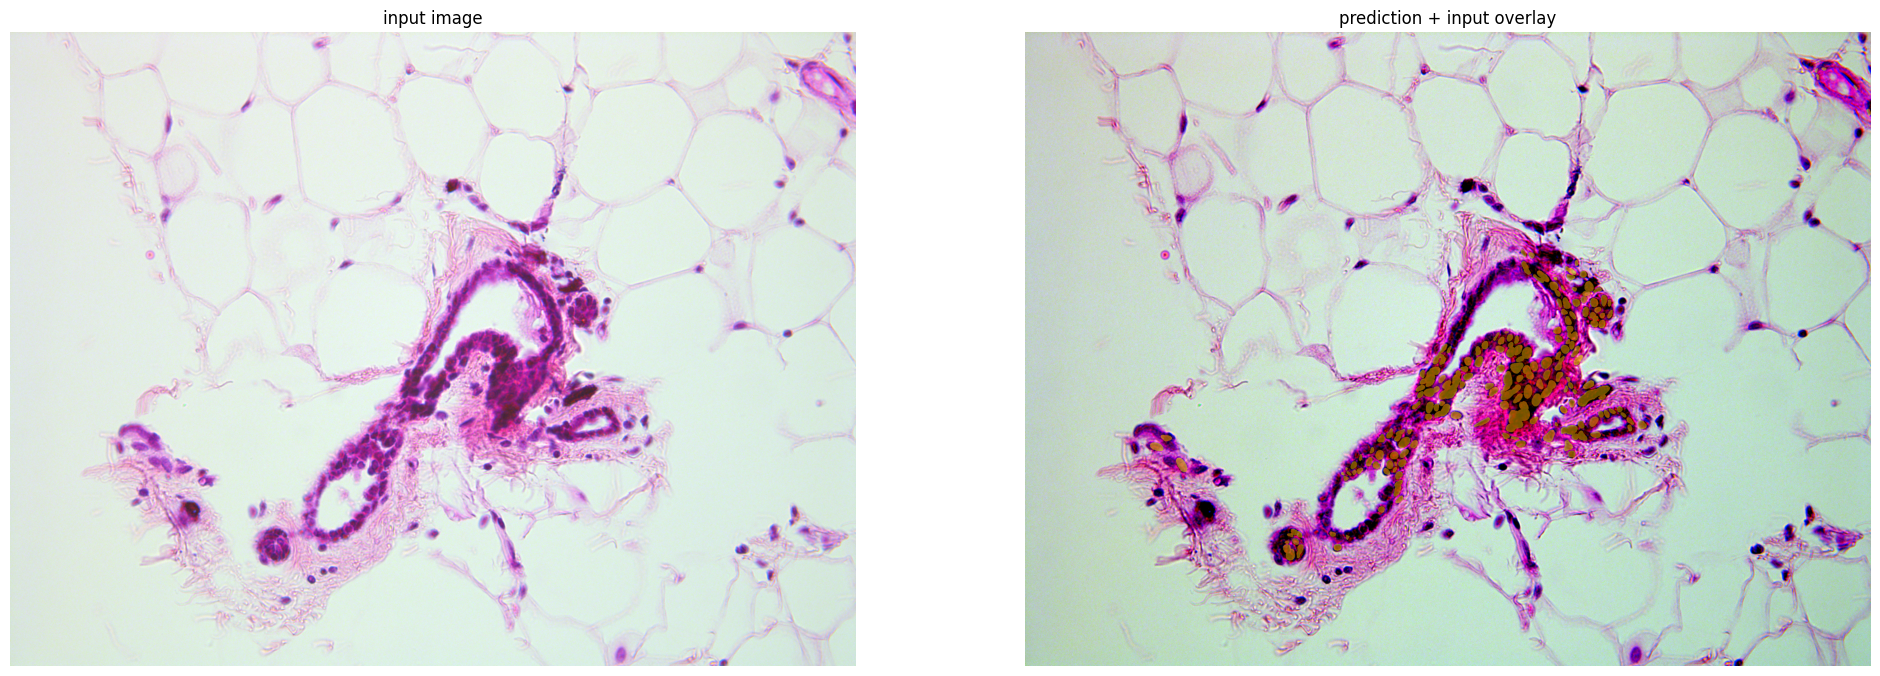

In [27]:
plt.figure(figsize=(24, 12))

plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.axis("off")
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(render_label(test_labels, img=test_image, cmap=(1.0, 1.0, 0), alpha=0.6))
plt.axis("off")
plt.title("prediction + input overlay")

plt.show()

In [ ]:
def extract_stardist_features(
    labels: NDArray[np.floating], data_dict: Dict[str, NDArray[np.floating]]
) -> pd.DataFrame:
    """
    Extract features from StarDist segmentation results

    Parameters:
    -----------
    labels : numpy.ndarray
        Instance segmentation mask from StarDist
    data_dict : dict
        Dictionary returned by StarDist with 'coord', 'points', 'prob'

    Returns:
    --------
    pandas.DataFrame
        DataFrame with features for each detected object
    """

    props = regionprops(labels)

    coordinates = data_dict.get("coord", [])
    points = data_dict.get("points", [])
    probabilities = data_dict.get("prob", [])

    features = []

    for i, prop in enumerate(props):
        feature_dict = {
            "label_id": prop.label,
            "area": prop.area,
            "perimeter": prop.perimeter,
            "centroid_y": prop.centroid[0],
            "centroid_x": prop.centroid[1],
            "bbox_min_row": prop.bbox[0],
            "bbox_min_col": prop.bbox[1],
            "bbox_max_row": prop.bbox[2],
            "bbox_max_col": prop.bbox[3],
            "eccentricity": prop.eccentricity,
            "solidity": prop.solidity,
            "extent": prop.extent,
            "major_axis_length": prop.major_axis_length,
            "minor_axis_length": prop.minor_axis_length,
            "orientation": prop.orientation,
            "equivalent_diameter": prop.equivalent_diameter,
        }

        if i < len(probabilities):
            feature_dict["stardist_probability"] = probabilities[i]

        if i < len(coordinates):
            feature_dict["stardist_distances_y"] = (
                coordinates[i][0] if len(coordinates[i]) > 0 else None
            )
            feature_dict["stardist_distances_x"] = (
                coordinates[i][1] if len(coordinates[i]) > 1 else None
            )

        features.append(feature_dict)

    return pd.DataFrame(features)

In [11]:
test_features = extract_stardist_features(test_labels, test_data_dict)
test_features.head()

,label_id,area,perimeter,centroid_y,centroid_x,bbox_min_row,bbox_min_col,bbox_max_row,bbox_max_col,eccentricity,solidity,extent,major_axis_length,minor_axis_length,orientation,equivalent_diameter,stardist_probability,stardist_center_y,stardist_center_x
0,1,406.0,72.769553,1312.288177,1062.248768,1301,1051,1324,1074,0.451413,0.971292,0.767486,24.088287,21.494347,0.703134,22.736210,0.875039,"[1312.0, 1314.342, 1316.8495, 1319.0898, 1320....","[1073.5924, 1073.7742, 1073.7076, 1072.6107, 1..."
1,2,455.0,77.355339,820.918681,1667.496703,810,1656,834,1680,0.435192,0.972222,0.789931,25.422542,22.888872,0.809791,24.069150,0.863121,"[820.0, 822.27686, 824.7142, 826.9237, 828.968...","[1679.4803, 1679.4465, 1679.3811, 1678.362, 16..."
2,3,430.0,76.183766,929.551163,1613.618605,918,1602,942,1626,0.626431,0.964126,0.746528,26.526159,20.676537,0.736204,23.398568,0.856458,"[930.0, 932.2486, 934.6319, 936.742, 938.72314...","[1625.405, 1625.3046, 1625.1824, 1624.0901, 16..."
3,4,389.0,73.355339,1278.601542,1653.652956,1268,1642,1290,1666,0.463502,0.944175,0.736742,23.657678,20.962966,-1.435470,22.255116,0.851922,"[1278.0, 1280.1886, 1282.4078, 1284.3732, 1286...","[1665.3243, 1665.0027, 1664.6414, 1663.5382, 1..."
4,5,430.0,75.597980,1342.658140,1130.486047,1331,1120,1356,1143,0.664731,0.977273,0.747826,27.142647,20.277815,-0.664236,23.398568,0.847252,"[1342.0, 1344.2825, 1346.321, 1347.9503, 1349....","[1142.5894, 1141.4747, 1140.4319, 1138.9053, 1..."
